In [1]:
from collections import OrderedDict, defaultdict
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('dark_background')

In [2]:
from get_observed import get_samples
from heston import infer_heston_parameters, Heston

# Heston Model

The Heston model assumes that the price of an asset $S$ satisfies a stochastic differential equation (SDE)

$$ \operatorname{d}S_t = rS_t\operatorname{d}t + \sqrt{\nu_t}S_t\operatorname{d}W^1_t $$
$$ \operatorname{d}\nu_t = \eta(\theta-\nu_t)\operatorname{d}t + \xi\sqrt{\nu_t}\operatorname{d}W^2_t $$

$t$ is for time; $r, \theta, \eta, \xi$ are scalar parameters; $\nu$ is the instantaneous variance of $S$; and $W^1, W^2$ are Brownian motions (with correlation $\rho$, which I ignore here).

The SDE is a continuous-time model, so $t\in[0;\infty)$.

In practice, we only have finitely many observations at finitely many times $t_1, ..., t_N$ and we may discretize the above SDE:
$$ S_{t_{n+1}}-S_{t_n} = rS_{t_n}(t_{n+1}-t_n) + \sqrt{\nu_{t_n}}S_{t_n}\sqrt{t_{n+1}-t_n}\mathcal{N}(0, 1) $$
$$ \nu_{t_{n+1}}-\nu_{t_n} = \eta(\theta-\nu_{t_n})(t_{n+1}-t_n) + \xi\sqrt{\nu_{t_n}}\sqrt{t_{n+1}-t_n}\mathcal{N}(0, 1) $$

In this notebook, we want to estimate $r, \theta, \eta, \xi$ from given observations $S_{t_0}, \dots, S_{t_N}$.

## Step 1: Retrieve Observations

We consider trajectories of the price of a `STOCK_NAME` over `PREDICITON_PERIOD` days, so $N=$`PREDICITON_PERIOD`.
Each of the `NUM_SAMPLES` trajectories corresponds to a time window between `START` and `END`.

In [3]:
STOCK_NAMES = ["ADBE", "MSFT", "ORCL", "WBD", "TSLA", "INTC", "AAL", "AAPL", "NSRGY", "NVS", "RHHBY"]
PREDICITON_PERIOD = 60
INTERVAL = "1d"

NUM_SAMPLES = 1000
START = datetime(2020, 1, 1)
END = datetime(2024, 1, 1)

The prices $S$ are directly available on the internet. Given the above discrete SDE, we can* also infer $\nu$ from $S$:
$$ \nu_{t_n} = \operatorname{var}\left[\frac{S_{t_{k+1}}-S_{t_k}-r_{t_k}S_{t_k}(t_{k+1}-t_k)}{S_{t_k}\sqrt{t_{k+1}-t_k}}\right]_{k=n-L}^n$$
with
$$ r_{t_k} = \mathbb{E}\left[\frac{S_{t_{\ell+1}}-S_{t_\ell}}{S_{t_\ell}(t_{\ell+1}-t_\ell)}\right]_{\ell=k-L/2}^{k+L/2} $$
_*Or say, that's how I decided to do it: I consider a local drift $r_{t_k}$ and interpret $\nu_{t_n}$ as how much the price deviates from that drift, locally._

$L=$`LOCAL_WINDOW_SIZE` determines how many timestamps we consider when saying "locally".

In [4]:
LOCAL_WINDOW_SIZE = 5

Now we are ready to sample `NUM_SAMPLES` trajectories $(S, \nu)$:

In [5]:
trajectories = get_samples(STOCK_NAMES, START, END, PREDICITON_PERIOD, interval=INTERVAL, local_window_size=LOCAL_WINDOW_SIZE, sample_size=NUM_SAMPLES)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Step 2: Infer $r, \theta, \eta, \xi$

$\theta$ is the mean of $\nu$:
$$ \theta = \mathbb{E}\left[\nu_{t_n}\right]_{n=1}^{N} $$

Moreover, the above discrete SDE implies
$$ r = \mathbb{E}\left[\frac{S_{t_{n+1}}-S_{t_n}}{S_{t_n}(t_{n+1}-t_n)}\right]_{n=1}^{N} $$
$$ \eta = \mathbb{E}\left[\frac{\nu_{t_{n+1}}-\nu_{t_n}}{(\theta-\nu_{t_n})(t_{n+1}-t_n)}\right]_{n=1}^{N} $$
$$ \xi = \operatorname{std}\left[\frac{\nu_{t_{n+1}}-\nu_{t_n}-\eta(\theta-\nu_{t_n})(t_{n+1}-t_n)}{\sqrt{\nu_{t_n}(t_{n+1}-t_n)}}\right]_{n=1}^{N} $$

## Step 3: Solve the SDE

Having inferred $r, \theta, \eta, \xi$, we can solve the Heston SDE for given initial prices (i.e. at $t_0$) and thereby get predictions for the evolution of the stock price.

In [6]:
NUM_SIMULATIONS = 64
DT = 1

In [7]:
actual_and_predictions = {}

for trajectory_name, trajectory in trajectories.items():
    parameters = infer_heston_parameters(trajectory)
    heston = Heston(**parameters)
    predictions = heston.predict(trajectory, num_simulations=NUM_SIMULATIONS, dt=DT)

    actual_and_predictions[trajectory_name] = (trajectory, predictions, parameters)

Let us look at `NUM_PLOTS` of these predictions.

In [8]:
NUM_PLOTS = 10

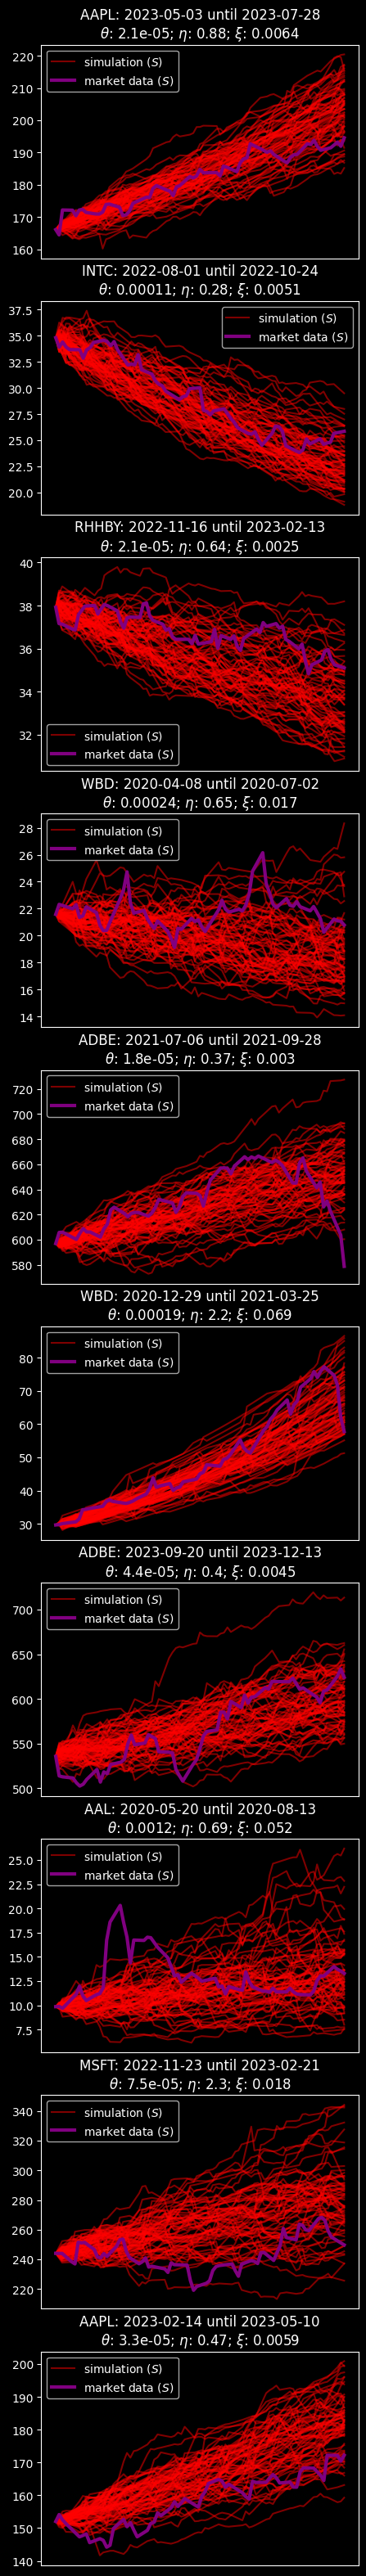

In [9]:
fig, axs = plt.subplots(NUM_PLOTS, 1)
fig.set_size_inches(5, 4 * NUM_PLOTS)

for i, (trajectory_name, (actual, predictions, parameters)) in enumerate(actual_and_predictions.items()):
    for j, prediction in enumerate(predictions[..., 0].transpose(0, 1)):
        axs[i].plot(actual.index, prediction.detach(), c="red", alpha=.5, label="simulation ($S$)" if j == 0 else None)
    axs[i].plot(actual.index, list(actual["S"]), c="purple", linewidth=3, label="market data ($S$)")
    parameter_string = "; ".join([f"$\\{p}$: {parameters[p]:.2g}"for p in parameters if p != "r"])
    axs[i].set_title(trajectory_name + f"\n{parameter_string}")
    axs[i].legend()
    axs[i].set_xticks([])
    if i == NUM_PLOTS - 1:
        break

plt.show()

## Step 4: Check Plausibility

We have inferred $r, \theta, \eta, \xi$ under the assumption that our observations actually "are" a Heston process - which, of course, is not true.

We will perform two (visual) checks to ensure that our predictions make sense.

### Check 4.1: Terminal State

We want our mean predicted terminal state to match the actual terminal state.

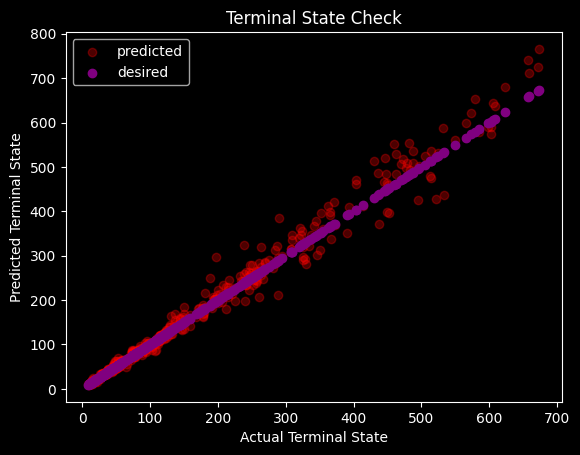

In [13]:
actual_terminals, predicted_terminals = OrderedDict(), OrderedDict()

for trajectory_name, (actual, predictions, parameters) in actual_and_predictions.items():
    actual_terminal_state = actual.iloc[-1]["S"]
    predicted_terminal_states = predictions[-1, ..., 0]
    actual_terminals[actual.index[0].date()] = actual_terminal_state
    predicted_terminals[actual.index[0].date()] = predicted_terminal_states.numpy().mean()

plt.scatter(actual_terminals.values(), predicted_terminals.values(), label="predicted", color="red", alpha=.3)
plt.scatter(actual_terminals.values(), actual_terminals.values(), label="desired", color="purple")
plt.xlabel("Actual Terminal State")
plt.ylabel("Predicted Terminal State")
plt.legend()
plt.title("Terminal State Check")
plt.show()


### Check 4.2: Distribution of Price Quotients at $t_n$

Here we compare histograms of $\frac{S_{t_n}}{S_{t_0}}$. We want the actual and the predicted histogram to look similar and in particular, we want similar means and variances.

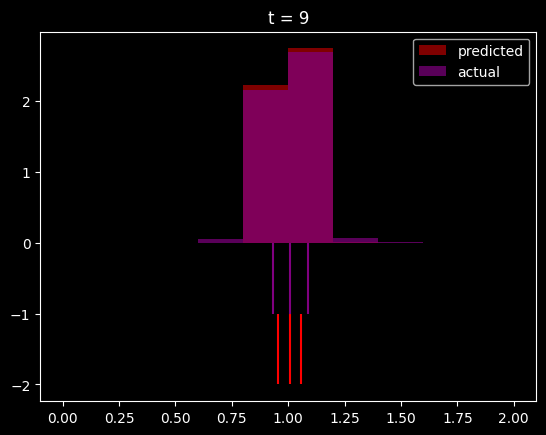

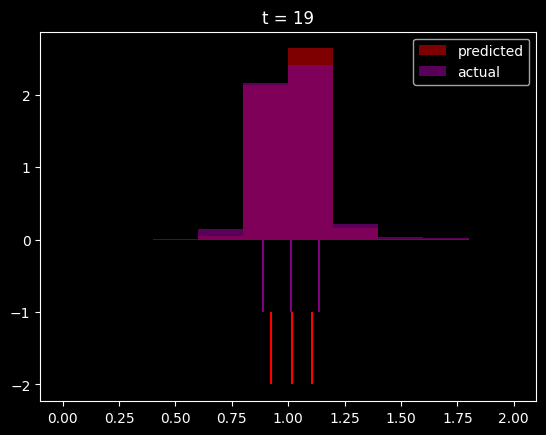

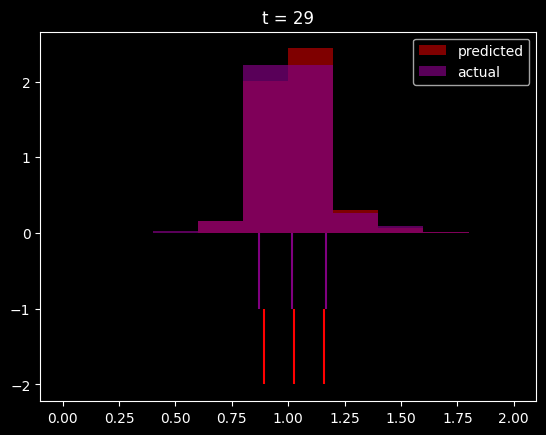

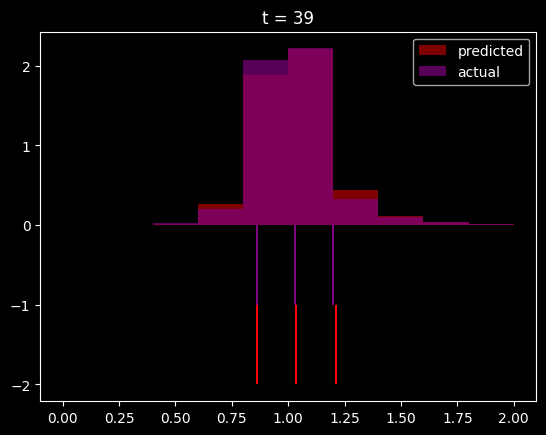

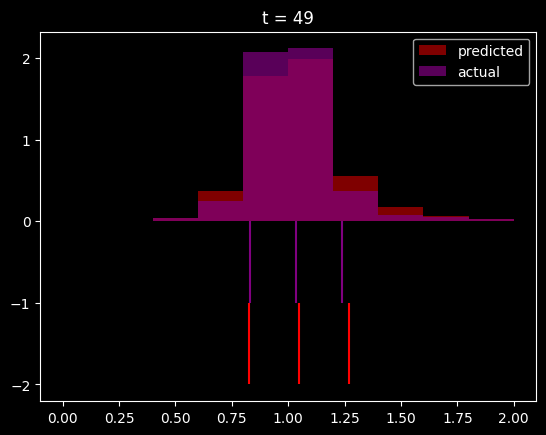

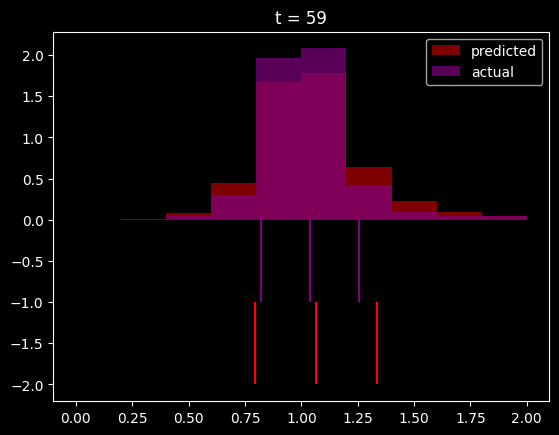

In [11]:
actual_distribution, predicted_distribution = defaultdict(list), defaultdict(list)
time_range = range(9, PREDICITON_PERIOD, 10)

for trajectory_name, (actual, predictions, parameters) in actual_and_predictions.items():
    actual, predictions = np.array(actual["S"]), predictions[..., 0]
    actual, predictions = actual / actual[0], predictions / predictions[0]
    for t in time_range:
        actual_distribution[t].append(actual[t])
        predicted_distribution[t].extend(predictions[t])


def vlines(distribution):
    mean = np.mean(distribution)
    std = np.std(distribution)
    return [mean - std, mean, mean + std]


for t in time_range:
    plt.hist(predicted_distribution[t], range=(0, 2), histtype="stepfilled", density=True, color="red", alpha=.5, label="predicted")
    plt.vlines(vlines(predicted_distribution[t]), ymin=-2, ymax=-1, color="red")
    plt.hist(actual_distribution[t], range=(0, 2), histtype="stepfilled", density=True, color="purple", alpha=.7, label="actual")
    plt.vlines(vlines(actual_distribution[t]), ymin=-1, ymax=0, color="purple")
    plt.title(f"t = {t}")
    plt.legend()
    plt.show()

## Comparison to Geometric Brownian Motion